In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Just a formatting related plugin
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [158]:
import torch
import numpy as np
import tqdm
import pandas as pd
from joblib import Parallel, delayed
import lightgbm as lgbm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pickle
from sklearn.model_selection import train_test_split
import shap
import seaborn as sns

import sbi
from sbi import utils as utils
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

<IPython.core.display.Javascript object>

In [5]:
sbi.__version__

'0.14.2'

<IPython.core.display.Javascript object>

In [6]:
torch.device("cuda")

device(type='cuda')

<IPython.core.display.Javascript object>

In [7]:
torch.get_num_threads()

8

<IPython.core.display.Javascript object>

In [8]:
torch.set_num_threads(16)

<IPython.core.display.Javascript object>

In [9]:
# tqdm custom context for joblib jobs
import contextlib
import joblib
from tqdm import tqdm
from joblib import Parallel, delayed


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

<IPython.core.display.Javascript object>

# A basic model of review generation

This is a probabilistic model of a single customer's journey. Eventually, the simulation works by picking a random number of reviews that needs to generated and simulating new customers till that number of reviews has been achieved (or, a max number of simulated customers has been hit). This process makes it possible to generate review distributions with different total number of reviews irrespective of the value of $\rho$, the parameter that controls the energy barrier to reviewing.

**Note: = denotes equality, ~ denotes a single draw from a probability distribution**

**For a single customer**, they begin with a prior for the review distribution of a product and the currently existing review distribution for the same product. Both of these are Dirichlet-distributed as follows:

Review distribution prior for arriving customer (same for every customer and product):
$$
\text{Prior} = Dirichlet(\alpha_1,..,\alpha_5=1.0)
$$

Existing distribution for product:
$$
\text{Reviews} = Dirichlet(\beta_1,..,\beta_5), \beta_i=\text{Currently existing number of reviews with rating=i}
$$

Customer adds the review numbers of the prior and existing distribution to form a posterior of "quality":
$$
\text{Quality posterior} = \text{Prior}+\text{Reviews} = Dirichlet(\alpha_1+\beta_1,..,\alpha_5+\beta_5)
$$

Customer now pulls a single multinomial distribution from the quality posterior - this is their "expected" distribution of experience (combines quality and idiosyncratic fit):
$$
\text{Expected distribution of experience} = Multinomial(\sum_{i=1}^{i=5}p_i=1) \sim \text{Quality posterior}  
$$

Once customer buys the product, they draw an actual "experience" from their multinomial distribution of expected experience. The actual experience is an integer from 1 to 5:
$$
\text{Experience} \sim Utility \in [1, 5]
$$

Now customer calculates the difference between their "actual" experience and the mean of their "expected" experience:
$$
\Delta = \text{Experience} - \sum_{i=1}^{i=5}(i \times p_i)
$$

Customer uses this difference to decide on the rating they will give to the product:
$$
\text{Rating} = 
\begin{cases}
    1,& \text{if } \Delta \in (-\infty, -1.5] \\
    2,& \text{if } \Delta \in (-1.5, -0.5] \\
    3,& \text{if } \Delta \in (-0.5, 0.5] \\
    4,& \text{if } \Delta \in (0.5, 1.5] \\
    5,& \text{if } \Delta \in (1.5, \infty) 
\end{cases}
$$

**Now, customer leaves a rating by comparing $\Delta$ to the cost of rating, $\rho$.**

We have different $\rho$ for positive and negative $\Delta$, and the customer leaves their rating in any of the following situations:
1. A small, baseline probability of leaving the rating through *tendency to rate* (set equal to 5% = 0.05)
2. If $\Delta \geq 0$ and $|\Delta| \geq \rho_+$
3. If $\Delta < 0$ and $|\Delta| \geq \rho_-$

# The simulation model, in numpy (which turned out to be faster than PyTorch for simulations)

In [10]:
# 2 parameters, positive and negative rho
prior = utils.BoxUniform(
    low=torch.tensor([0.0, 0.0]).type(torch.FloatTensor),
    high=torch.tensor([4.0, 4.0]).type(torch.FloatTensor),
)

<IPython.core.display.Javascript object>

In [11]:
# The function that simulates 1 visitor's journey (which may or may not end in review generation)
def visitor_journey(rev_prior, sim_revs, rho):
    # Convolve the current simulated review distribution with the prior to get the posterior of reviews
    post_revs_conc_params = sim_revs + rev_prior

    # Just make a single draw from the posterior Dirichlet dist of reviews to get the utility distribution
    expected_dist = np.random.dirichlet(post_revs_conc_params)

    expected_dist_mean = np.sum(expected_dist * np.arange(1, 6))

    # Draw an experience from the user's expected distribution
    experience = np.where(np.random.multinomial(1, expected_dist))[0][0] + 1.0

    # Compare the mismatch in experience to rho
    delta = experience - expected_dist_mean

    # Rating calculation step
    if delta <= -1.5:
        review = 0
    elif delta > -1.5 and delta <= -0.5:
        review = 1
    elif delta > -0.5 and delta <= 0.5:
        review = 2
    elif delta > 0.5 and delta <= 1.5:
        review = 3
    else:
        review = 4

    # Decision to rate step
    # Return the review only if mismatch is higher than rho
    if np.random.random() <= 0.05:  # tendency_to_rate:
        return review
    elif delta < 0 and np.abs(delta) >= rho[0]:
        return review
    elif delta >= 0 and np.abs(delta) >= rho[1]:
        return review
    else:
        return None

<IPython.core.display.Javascript object>

In [12]:
# This runs the model by:
# Picking a number of reviews that needs to be generated
# and simulating visitors either till that number or a max number of visitors has been reached
def model(rho):
    # Total number of reviews we want in this simulation
    revs_num = np.random.randint(low=20, high=3001)

    # Absolute total number of visitors - if we hit this number but haven't gotten revs_num reviews
    # we will stop with whatever reviews we have at that point
    total_visitors = revs_num * 30

    rev_prior = np.ones(5)

    # Simulated distribution of reviews
    sim_revs = np.zeros(5)

    for visitor in range(total_visitors):
        index = visitor_journey(rev_prior, sim_revs, rho)
        if index is not None:
            sim_revs[index] += 1
        if np.sum(sim_revs) >= revs_num:
            break
    return sim_revs

<IPython.core.display.Javascript object>

In [14]:
# Get the observed counts of total number of reviews - will be used to pick the
# total number of reviews to be simulated
ratings = pd.read_csv("rating_snpe/rating_hist_speakers_snpe.txt", sep="\t")
total_ratings = np.array(ratings.iloc[:, 1:].sum(axis=1))
total_ratings[:10]

array([1249, 1079,  962, 3404,  444, 2810,  124,  302, 1263,  163])

<IPython.core.display.Javascript object>

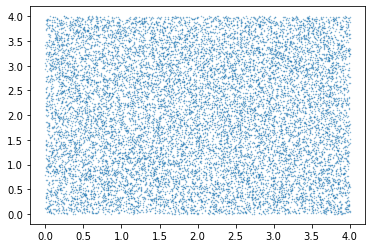

<IPython.core.display.Javascript object>

In [13]:
n_simulations = 15_000
rho = np.vstack(
    (np.random.random(size=n_simulations) * 4, np.random.random(size=n_simulations) * 4)
).T
plt.scatter(rho[:, 0], rho[:, 1], alpha=0.6, s=0.2)

In [14]:
with tqdm_joblib(tqdm(desc="Simulations", total=n_simulations)) as progress_bar:
    output = Parallel(n_jobs=16)(delayed(model)(rho[i, :]) for i in range(rho.shape[0]))

Simulations: 100%|██████████| 15000/15000 [18:27<00:00, 13.55it/s] 


<IPython.core.display.Javascript object>

In [15]:
output = np.array(output)
print(output.shape)
np.save("rating_snpe/simulated_output.npy", output)
np.save("rating_snpe/rho_for_simulations.npy", rho)

(15000, 5)


<IPython.core.display.Javascript object>

In [13]:
# Load up pre-saved data
output = np.load("rating_snpe/simulated_output.npy")
rho = np.load("rating_snpe/rho_for_simulations.npy")

<IPython.core.display.Javascript object>

In [15]:
output.shape

(15000, 5)

<IPython.core.display.Javascript object>

In [16]:
# Convert everything into torch tensors to be fed into SNPE
output = torch.from_numpy(output).type(torch.FloatTensor)
# theta = torch.from_numpy(theta).type(torch.FloatTensor)
theta = torch.from_numpy(rho).type(torch.FloatTensor)

<IPython.core.display.Javascript object>

In [17]:
inference = SNPE(prior, device="cpu", show_progress_bars=True)

<IPython.core.display.Javascript object>

In [18]:
density_estimator = inference.append_simulations(theta, output).train(
    training_batch_size=50, show_train_summary=True
)

Neural network successfully converged after 188 epochs.

        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 188
        Best validation performance: -0.1169
        -------------------------
        


<IPython.core.display.Javascript object>

In [19]:
posterior = inference.build_posterior(density_estimator)

<IPython.core.display.Javascript object>

In [20]:
data1 = model(np.array([3.5, 1.9]))
data2 = model(np.array([0.7, 2.2]))
data3 = model(np.array([1.1, 0.5]))
print(data1)
print(data2)
print(data3)

[246. 267. 259. 442. 439.]
[461. 150.   3.   0. 376.]
[ 767.  125.    0. 1016.  732.]


<IPython.core.display.Javascript object>

In [21]:
# samples = posterior.sample((10000,), x=torch.tensor([50.0, 30.0, 20.0, 100.0, 200.0]))
samples1 = posterior.sample((10000,), x=torch.tensor(data1).type(torch.FloatTensor))
samples2 = posterior.sample((10000,), x=torch.tensor(data2).type(torch.FloatTensor))
samples3 = posterior.sample((10000,), x=torch.tensor(data3).type(torch.FloatTensor))

<IPython.core.display.Javascript object>

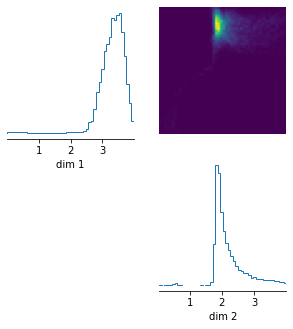

<IPython.core.display.Javascript object>

In [22]:
_ = utils.pairplot(samples1, fig_size=(5, 5))

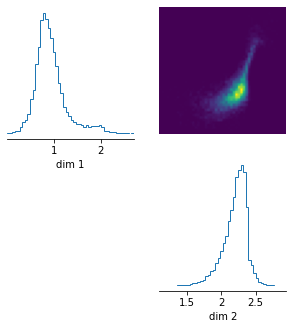

<IPython.core.display.Javascript object>

In [23]:
_ = utils.pairplot(samples2, fig_size=(5, 5))

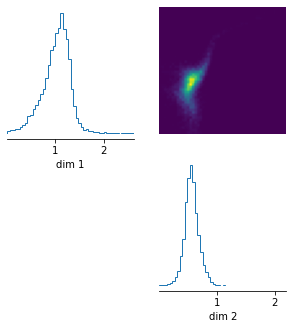

<IPython.core.display.Javascript object>

In [24]:
_ = utils.pairplot(samples3, fig_size=(5, 5))

In [25]:
# Pickle the posterior
import pickle

with open("rating_snpe/sbi_posterior_double_rho.pkl", "wb") as f:
    pickle.dump(posterior, f)

<IPython.core.display.Javascript object>

# Using the trained network to infer the posterior on real products

In [10]:
with open("rating_snpe/sbi_posterior_double_rho.pkl", "rb") as f:
    posterior = pickle.load(f)
posterior

DirectPosterior(
               method_family=snpe,
               net=<a Flow, see `.net` for details>,
               prior=BoxUniform(Uniform(low: torch.Size([2]), high: torch.Size([2])), 1),
               x_shape=torch.Size([1, 5]))
               

<IPython.core.display.Javascript object>

In [11]:
# Load up the data
ratings = pd.read_csv("rating_snpe/rating_hist_speakers_snpe.txt", sep="\t")
features = pd.read_csv("rating_snpe/prod_price_brand_snpe.txt", sep="\t")

<IPython.core.display.Javascript object>

In [12]:
ratings.head()

,asin,1,2,3,4,5
0,B00000K2YR,155,99,109,247,639
1,B00001P4XA,102,105,128,222,522
2,B00001P4XH,85,64,102,190,521
3,B00001P4ZH,105,107,220,643,2329
4,B00001P505,17,25,26,124,252


<IPython.core.display.Javascript object>

In [13]:
features.head()

,asin,val,productGroup,brand
0,B00000K2YR,77.860,Speakers,Midland
1,B00001P4XA,17.530,Speakers,Koss
2,B00001P4XH,9.010,Speakers,Koss
3,B00001P4ZH,39.355,Speakers,Koss
4,B00001P505,22.955,Speakers,Koss


<IPython.core.display.Javascript object>

In [14]:
len(ratings) == len(features)

True

<IPython.core.display.Javascript object>

In [15]:
# Sort the rows of features in the same order as the rows in ratings by asin
features = features.set_index("asin")
features = features.reindex(index=ratings["asin"])
features = features.reset_index()
print(np.all(features["asin"] == ratings["asin"]))
features.head()

True


,asin,val,productGroup,brand
0,B00000K2YR,77.860,Speakers,Midland
1,B00001P4XA,17.530,Speakers,Koss
2,B00001P4XH,9.010,Speakers,Koss
3,B00001P4ZH,39.355,Speakers,Koss
4,B00001P505,22.955,Speakers,Koss


<IPython.core.display.Javascript object>

In [16]:
# Add number of reviews to features
features["num_reviews"] = np.array(ratings.iloc[:, 1:]).sum(axis=1)
features.head()

,asin,val,productGroup,brand,num_reviews
0,B00000K2YR,77.860,Speakers,Midland,1249
1,B00001P4XA,17.530,Speakers,Koss,1079
2,B00001P4XH,9.010,Speakers,Koss,962
3,B00001P4ZH,39.355,Speakers,Koss,3404
4,B00001P505,22.955,Speakers,Koss,444


<IPython.core.display.Javascript object>

In [17]:
# Add top_10 to features
features["top_10"] = features["brand"].isin(
    np.array(features["brand"].value_counts()[:10].index)
)
features["top_10"] = ["Y" if i else "N" for i in features["top_10"]]
features.head()

,asin,val,productGroup,brand,num_reviews,top_10
0,B00000K2YR,77.860,Speakers,Midland,1249,N
1,B00001P4XA,17.530,Speakers,Koss,1079,N
2,B00001P4XH,9.010,Speakers,Koss,962,N
3,B00001P4ZH,39.355,Speakers,Koss,3404,N
4,B00001P505,22.955,Speakers,Koss,444,N


<IPython.core.display.Javascript object>

In [18]:
# Add log price and log num reviews to features
for column in ["val", "num_reviews"]:
    features[f"log_{column}"] = np.log(features[column] + 1)
features.head()

,asin,val,productGroup,brand,num_reviews,top_10,log_val,log_num_reviews
0,B00000K2YR,77.860,Speakers,Midland,1249,N,4.367674,7.130899
1,B00001P4XA,17.530,Speakers,Koss,1079,N,2.919391,6.984716
2,B00001P4XH,9.010,Speakers,Koss,962,N,2.303585,6.870053
3,B00001P4ZH,39.355,Speakers,Koss,3404,N,3.697715,8.133000
4,B00001P505,22.955,Speakers,Koss,444,N,3.176177,6.098074


<IPython.core.display.Javascript object>

In [34]:
features["log_val"]

0      4.367674
1      2.919391
2      2.303585
3      3.697715
4      3.176177
         ...   
954    5.829071
955    4.191925
956    4.750309
957    3.931630
958    3.617383
Name: log_val, Length: 959, dtype: float64

<IPython.core.display.Javascript object>

In [19]:
num_samples = 5_000
inferred_rho = np.zeros((len(features), num_samples, 2)) + np.nan

<IPython.core.display.Javascript object>

In [20]:
ratings.iloc[0, 1:]

1    155
2     99
3    109
4    247
5    639
Name: 0, dtype: object

<IPython.core.display.Javascript object>

In [21]:
# Now run through the products, get the posterior over rho for each of them, and save
# that posterior in the right index of inferred_rho aligned with features DF
for row in range(len(ratings)):
    obs_ratings = np.array(ratings.iloc[row, 1:], dtype=np.float64)
    posterior_samples = posterior.sample(
        (num_samples,),
        x=torch.tensor(obs_ratings).type(torch.FloatTensor),
        show_progress_bars=False,
    ).numpy()
    inferred_rho[row, :, :] = posterior_samples

<IPython.core.display.Javascript object>

In [23]:
# Check that all rows of inferred rho have been filled in
np.sum(np.isnan(inferred_rho))

0

<IPython.core.display.Javascript object>

# Gradient boosted trees to predict rho on the basis of product features

In [39]:
# We repeat rows of products for all num_samples number of posterior samples
expanded_features = pd.DataFrame(np.repeat(features.values, num_samples, axis=0))
expanded_features.columns = features.columns
expanded_features = expanded_features.astype(
    {col: dtype for (col, dtype) in zip(features.columns, features.dtypes)}
)
print(expanded_features.shape)
expanded_features.head()

(4795000, 8)


,asin,val,productGroup,brand,num_reviews,top_10,log_val,log_num_reviews
0,B00000K2YR,77.86,Speakers,Midland,1249,N,4.367674,7.130899
1,B00000K2YR,77.86,Speakers,Midland,1249,N,4.367674,7.130899
2,B00000K2YR,77.86,Speakers,Midland,1249,N,4.367674,7.130899
3,B00000K2YR,77.86,Speakers,Midland,1249,N,4.367674,7.130899
4,B00000K2YR,77.86,Speakers,Midland,1249,N,4.367674,7.130899


<IPython.core.display.Javascript object>

In [40]:
expanded_features.dtypes

asin                object
val                float64
productGroup        object
brand               object
num_reviews          int64
top_10              object
log_val            float64
log_num_reviews    float64
dtype: object

<IPython.core.display.Javascript object>

In [41]:
# Now run through the products, and assign their inferred rhos in expanded features
rho_0 = np.zeros(len(expanded_features)) + np.nan
rho_1 = np.zeros(len(expanded_features)) + np.nan
for row in range(len(features)):
    rho_0[num_samples * row : num_samples * (row + 1)] = inferred_rho[row, :, 0]
    rho_1[num_samples * row : num_samples * (row + 1)] = inferred_rho[row, :, 1]

<IPython.core.display.Javascript object>

In [42]:
expanded_features["rho_0"] = rho_0
expanded_features["rho_1"] = rho_1
print(expanded_features.head())
print(
    np.sum(np.isnan(expanded_features.rho_0)), np.sum(np.isnan(expanded_features.rho_1))
)

         asin    val productGroup    brand  num_reviews top_10   log_val  \
0  B00000K2YR  77.86     Speakers  Midland         1249      N  4.367674   
1  B00000K2YR  77.86     Speakers  Midland         1249      N  4.367674   
2  B00000K2YR  77.86     Speakers  Midland         1249      N  4.367674   
3  B00000K2YR  77.86     Speakers  Midland         1249      N  4.367674   
4  B00000K2YR  77.86     Speakers  Midland         1249      N  4.367674   

   log_num_reviews     rho_0     rho_1  
0         7.130899  3.219454  1.706417  
1         7.130899  3.296607  1.783206  
2         7.130899  3.261473  1.645456  
3         7.130899  3.019448  1.537404  
4         7.130899  3.193421  1.681445  
0 0


<IPython.core.display.Javascript object>

In [43]:
# Convert categorical features to int
categorical_feature = ["top_10", "brand"]
categorical_codes = []
for feat in categorical_feature:
    expanded_features[feat] = expanded_features[feat].astype("category")
    categorical_codes.append(expanded_features[feat].cat.codes + 1)
    expanded_features[feat] = pd.Categorical(expanded_features[feat].cat.codes + 1)
expanded_features.head()

,asin,val,productGroup,brand,num_reviews,top_10,log_val,log_num_reviews,rho_0,rho_1
0,B00000K2YR,77.86,Speakers,141,1249,1,4.367674,7.130899,3.219454,1.706417
1,B00000K2YR,77.86,Speakers,141,1249,1,4.367674,7.130899,3.296607,1.783206
2,B00000K2YR,77.86,Speakers,141,1249,1,4.367674,7.130899,3.261473,1.645456
3,B00000K2YR,77.86,Speakers,141,1249,1,4.367674,7.130899,3.019448,1.537404
4,B00000K2YR,77.86,Speakers,141,1249,1,4.367674,7.130899,3.193421,1.681445


<IPython.core.display.Javascript object>

In [44]:
# Train test split (20% in test set)
covariates = ["brand", "log_val", "log_num_reviews", "top_10"]
labels = ["rho_0", "rho_1"]
X_train, X_test, y_train, y_test = train_test_split(
    expanded_features.loc[:, covariates],
    expanded_features.loc[:, labels],
    test_size=0.2,
    random_state=42,
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3836000, 4) (959000, 4) (3836000, 2) (959000, 2)


<IPython.core.display.Javascript object>

In [45]:
X_train.head()

,brand,log_val,log_num_reviews,top_10
3245761,116,3.178054,2.890372,1
3107397,129,4.875121,6.719013,1
3174778,3,4.962845,3.951244,1
3865942,164,2.686486,5.963579,2
3363611,69,3.594019,5.141664,1


<IPython.core.display.Javascript object>

In [64]:
model = lgbm.LGBMRegressor(
    num_leaves=5,
    max_depth=3,
    learning_rate=0.25,
    n_estimators=300,
    reg_lambda=1.0,
    silent=False,
)

<IPython.core.display.Javascript object>

In [65]:
model.fit(
    X=X_train,
    y=y_train.loc[:, "rho_1"],
    categorical_feature=["brand", "top_10"],
    eval_set=[(X_test, y_test.loc[:, "rho_0"])],
    early_stopping_rounds=10,
)

Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'top_10']


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 772
[LightGBM] [Info] Number of data points in the train set: 3836000, number of used features: 4


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 1.612463
[1]	valid_0's l2: 2.69076
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 2.71742
[3]	valid_0's l2: 2.73866
[4]	valid_0's l2: 2.75804
[5]	valid_0's l2: 2.77062
[6]	valid_0's l2: 2.78251
[7]	valid_0's l2: 2.79254
[8]	valid_0's l2: 2.80265
[9]	valid_0's l2: 2.80709
[10]	valid_0's l2: 2.80821
[11]	valid_0's l2: 2.81363
Early stopping, best iteration is:
[1]	valid_0's l2: 2.69076


LGBMRegressor(learning_rate=0.25, max_depth=3, n_estimators=300, num_leaves=5,
              reg_lambda=1.0, silent=False)

<IPython.core.display.Javascript object>

In [66]:
model.predict(expanded_features.loc[:, covariates].iloc[:10, :])

array([1.65190419, 1.65190419, 1.65190419, 1.65190419, 1.65190419,
       1.65190419, 1.65190419, 1.65190419, 1.65190419, 1.65190419])

<IPython.core.display.Javascript object>

In [67]:
expanded_features["rho_1"][:10]

0    1.706417
1    1.783206
2    1.645456
3    1.537404
4    1.681445
5    1.474149
6    1.726818
7    1.400299
8    1.515061
9    1.612559
Name: rho_1, dtype: float64

<IPython.core.display.Javascript object>

In [68]:
print(model.feature_importances_)
print(model.feature_name_)

[3 0 1 0]
['brand', 'log_val', 'log_num_reviews', 'top_10']


<IPython.core.display.Javascript object>

In [69]:
shap_values = shap.TreeExplainer(model).shap_values(X_test)

<IPython.core.display.Javascript object>

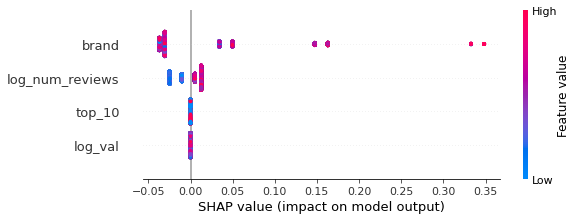

<IPython.core.display.Javascript object>

In [70]:
shap.summary_plot(shap_values[::100, :], X_test.iloc[::100, :])

In [71]:
shap_df = pd.DataFrame(shap_values, columns=model.feature_name_)
shap_df = shap_df.abs().sum().sort_values(ascending=False)
shap_df /= shap_df.sum()
feature_importances = shap_df.reset_index()
feature_importances.columns = ["feature", "importance"]
feature_importances["cum_importance"] = feature_importances["importance"].cumsum()
print(feature_importances)

           feature  importance  cum_importance
0            brand    0.770091        0.770091
1  log_num_reviews    0.229909        1.000000
2           top_10    0.000000        1.000000
3          log_val    0.000000        1.000000


<IPython.core.display.Javascript object>

# Linear regression

In [112]:
features["rho0"] = np.mean(inferred_rho, axis=1)[:, 0]
features["rho1"] = np.mean(inferred_rho, axis=1)[:, 1]
# features["sd_rho0"] = np.std(inferred_rho, axis=1)[:, 0]
# features["sd_rho1"] = np.std(inferred_rho, axis=1)[:, 1]
# features["num_reviews"] = np.array(ratings.iloc[:, 1:]).sum(axis=1)
# features["log_num_reviews"] = np.log(features["num_reviews"]) + 1
# features["log_val"] = np.log(features["val"]) + 1
features.head()

,asin,val,productGroup,brand,num_reviews,top_10,log_val,log_num_reviews,log_num_reviews_2,rho0,rho1
0,B00000K2YR,77.860,Speakers,Midland,1249,N,4.367674,7.130899,50.849718,3.170458,1.588642
1,B00001P4XA,17.530,Speakers,Koss,1079,N,2.919391,6.984716,48.786262,3.378448,1.590856
2,B00001P4XH,9.010,Speakers,Koss,962,N,2.303585,6.870053,47.197634,3.235844,1.490542
3,B00001P4ZH,39.355,Speakers,Koss,3404,N,3.697715,8.133000,66.145693,3.046916,1.473076
4,B00001P505,22.955,Speakers,Koss,444,N,3.176177,6.098074,37.186510,3.451694,1.557464


<IPython.core.display.Javascript object>

In [111]:
features["log_num_reviews_2"] = features["log_num_reviews"] ** 2

<IPython.core.display.Javascript object>

In [155]:
# model = smf.ols(formula="rho1 ~ log_num_reviews + log_num_reviews_2", data=features)
model = smf.ols(formula="rho1 ~ log_val", data=features)

<IPython.core.display.Javascript object>

In [156]:
res = model.fit()

<IPython.core.display.Javascript object>

In [157]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   rho1   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     52.75
Date:                Sat, 09 Jan 2021   Prob (F-statistic):           7.83e-13
Time:                        15:44:15   Log-Likelihood:                -419.71
No. Observations:                 959   AIC:                             843.4
Df Residuals:                     957   BIC:                             853.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9788      0.052     38.139      0.0

<IPython.core.display.Javascript object>

In [164]:
print(list(features["brand"].value_counts()[:10].index))

['Sony', 'Pyle', 'Yamaha Audio', 'Sennheiser', 'Polk Audio', 'Philips', 'JBL', 'Bose', 'Sangean', 'Onkyo']


<IPython.core.display.Javascript object>

In [165]:
features["top_10"] = features["brand"].isin(
    np.array(features["brand"].value_counts()[:10].index)
)
features["top_10"] = ["Y" if i else "N" for i in features["top_10"]]
features.head()

,asin,val,productGroup,brand,rho0,rho1,sd_rho0,sd_rho1,num_reviews,log_num_reviews,log_val,top_10
0,B00000K2YR,77.860,Speakers,Midland,3.169074,1.586167,0.117180,0.090543,1249,8.130099,5.354912,N
1,B00001P4XA,17.530,Speakers,Koss,3.378743,1.590414,0.157094,0.077606,1079,7.983790,3.863914,N
2,B00001P4XH,9.010,Speakers,Koss,3.231060,1.488635,0.127975,0.099757,962,7.869014,3.198335,N
3,B00001P4ZH,39.355,Speakers,Koss,3.049267,1.474074,0.176458,0.154585,3404,9.132706,4.672623,N
4,B00001P505,22.955,Speakers,Koss,3.448437,1.555637,0.189911,0.103503,444,7.095825,4.133536,N


<IPython.core.display.Javascript object>

In [158]:
frequencies = features["brand"].value_counts()
condition = frequencies < 3  # you can define it however you want
mask_obs = frequencies[condition].index
mask_dict = dict.fromkeys(mask_obs, "miscellaneous")

features["brand"] = features["brand"].replace(mask_dict)

<IPython.core.display.Javascript object>

In [207]:
features["brand"].value_counts()

Sony            51
Pyle            49
Yamaha Audio    38
Sennheiser      35
Polk Audio      33
Philips         29
JBL             25
Bose            21
Sangean         20
Onkyo           18
Name: brand, dtype: int64

<IPython.core.display.Javascript object>

In [235]:
features = features.loc[
    features["brand"].isin(np.array(features["brand"].value_counts()[:10].index)), :
]
features.head()

,asin,val,productGroup,brand,rho0,rho1,num_reviews
5,B00001WRSJ,102.49,Speakers,Sony,2.999691,0.764781,2810
6,B0000228GF,38.53,Speakers,Sangean,2.454243,1.097253,124
11,B00005T3BD,106.94,Speakers,Polk Audio,2.850468,0.828088,828
12,B00005T3C8,118.95,Speakers,Polk Audio,2.810912,0.784848,542
13,B000065BPB,94.87,Speakers,Sennheiser,3.165608,0.745623,2568


<IPython.core.display.Javascript object>

In [236]:
features["log_val"] = np.log(features.loc[:, "val"] + 1)

<IPython.core.display.Javascript object>

In [237]:
features.head()


,asin,val,productGroup,brand,rho0,rho1,num_reviews,log_val
5,B00001WRSJ,102.49,Speakers,Sony,2.999691,0.764781,2810,4.639475
6,B0000228GF,38.53,Speakers,Sangean,2.454243,1.097253,124,3.677060
11,B00005T3BD,106.94,Speakers,Polk Audio,2.850468,0.828088,828,4.681576
12,B00005T3C8,118.95,Speakers,Polk Audio,2.810912,0.784848,542,4.787075
13,B000065BPB,94.87,Speakers,Sennheiser,3.165608,0.745623,2568,4.562993


<IPython.core.display.Javascript object>

In [143]:
from scipy.stats import describe

describe(features["num_reviews"])

DescribeResult(nobs=959, minmax=(2, 14378), mean=471.7653806047967, variance=1022955.5868587017, skewness=6.112164372704901, kurtosis=55.41179567451371)

<IPython.core.display.Javascript object>

In [144]:
np.percentile(features["num_reviews"], np.arange(1, 11, 1) * 10)

array([   27.8,    50.6,    76.4,   106. ,   159. ,   223.8,   339.6,
         559.8,  1055.6, 14378. ])

<IPython.core.display.Javascript object>

In [166]:
features = features.loc[features["num_reviews"] < 3000, :]
features.shape

(933, 12)

<IPython.core.display.Javascript object>

In [102]:
real = np.array(ratings.iloc[655, :])[1:].astype(np.float64)
real

array([ 4.,  2.,  3.,  2., 25.])

<IPython.core.display.Javascript object>

In [103]:
inferred_rho[655, :, :]

array([[3.42555332, 0.65376019],
       [2.5994668 , 1.28694487],
       [3.19829154, 1.91276538],
       ...,
       [2.63515306, 1.43366182],
       [2.59713078, 1.57585907],
       [2.31591821, 1.05983758]])

<IPython.core.display.Javascript object>

In [104]:
samples = posterior_samples = posterior.sample(
    (5000,),
    x=torch.tensor(real).type(torch.FloatTensor),
    show_progress_bars=False,
).numpy()

<IPython.core.display.Javascript object>

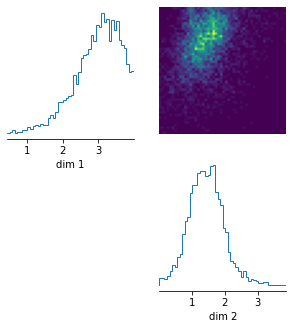

<IPython.core.display.Javascript object>

In [105]:
_ = utils.pairplot(inferred_rho[655, :, :], fig_size=(5, 5))

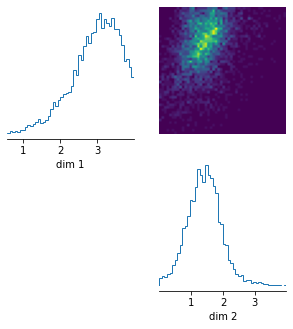

<IPython.core.display.Javascript object>

In [106]:
_ = utils.pairplot(samples, fig_size=(5, 5))

In [116]:
a = model([2.7, 1.5])

<IPython.core.display.Javascript object>

In [117]:
a

array([ 89.,   2.,   2.,  22., 161.])

<IPython.core.display.Javascript object>

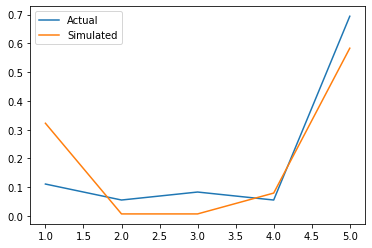

<IPython.core.display.Javascript object>

In [118]:
# plt.figure()
plt.plot(
    np.arange(1, 6),
    real / np.sum(real),
    label="Actual",
)
plt.plot(np.arange(1, 6), a / np.sum(a), label="Simulated")
plt.legend()

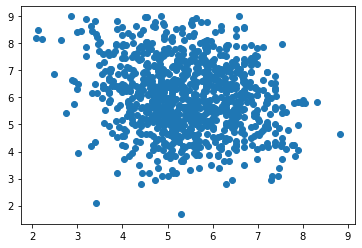

<IPython.core.display.Javascript object>

In [173]:
plt.scatter(features["log_val"], features["log_num_reviews"])

In [175]:
from scipy.stats import pearsonr

r = pearsonr(features["log_val"], features["log_num_reviews"])
r

(-0.1884499522708114, 6.610014280684171e-09)

<IPython.core.display.Javascript object>

In [54]:
m = np.mean(inferred_rho, axis=1)
m.shape

(959, 2)

<IPython.core.display.Javascript object>

In [119]:
sd = np.std(inferred_rho, axis=1)
sd.shape

(959, 2)

<IPython.core.display.Javascript object>

(array([  1.,   0.,   1.,   4.,   5.,  12.,  24.,  17.,  28.,  29.,  37.,
         44.,  72., 119.,  88., 101., 141., 116.,  81.,  39.]),
 array([1.43046001, 1.54800867, 1.66555732, 1.78310597, 1.90065463,
        2.01820328, 2.13575193, 2.25330059, 2.37084924, 2.48839789,
        2.60594654, 2.7234952 , 2.84104385, 2.9585925 , 3.07614116,
        3.19368981, 3.31123846, 3.42878711, 3.54633577, 3.66388442,
        3.78143307]),
 <BarContainer object of 20 artists>)

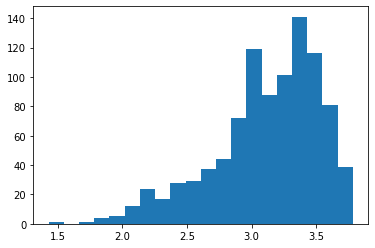

<IPython.core.display.Javascript object>

In [55]:
plt.hist(m[:, 0], bins=20)

(array([ 27.,  49.,  69., 160., 377.,  78.,  31.,  31.,  31.,  18.,  20.,
         15.,  14.,  12.,  10.,   4.,   5.,   6.,   1.,   1.]),
 array([0.96955419, 1.09359541, 1.21763664, 1.34167786, 1.46571909,
        1.58976031, 1.71380154, 1.83784276, 1.96188398, 2.08592521,
        2.20996643, 2.33400766, 2.45804888, 2.58209011, 2.70613133,
        2.83017255, 2.95421378, 3.078255  , 3.20229623, 3.32633745,
        3.45037868]),
 <BarContainer object of 20 artists>)

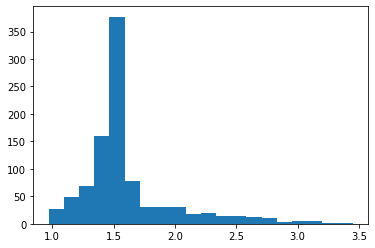

<IPython.core.display.Javascript object>

In [56]:
plt.hist(m[:, 1], bins=20)

(array([ 66., 202., 130.,  50.,  42.,  31.,  43.,  45.,  49.,  40.,  51.,
         74.,  58.,  37.,  13.,  13.,   9.,   4.,   1.,   1.]),
 array([0.08509483, 0.13862179, 0.19214874, 0.24567569, 0.29920264,
        0.3527296 , 0.40625655, 0.4597835 , 0.51331045, 0.5668374 ,
        0.62036436, 0.67389131, 0.72741826, 0.78094521, 0.83447217,
        0.88799912, 0.94152607, 0.99505302, 1.04857998, 1.10210693,
        1.15563388]),
 <BarContainer object of 20 artists>)

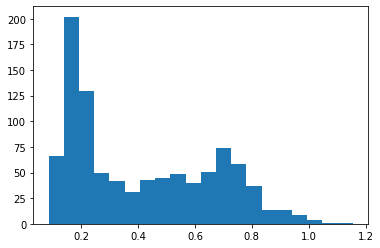

<IPython.core.display.Javascript object>

In [120]:
plt.hist(sd[:, 0], bins=20)

(array([108., 313.,  64.,  33.,  27.,  24.,  24.,  23.,  26.,  36.,  27.,
         23.,  28.,  34.,  19.,  47.,  52.,  39.,  10.,   2.]),
 array([0.03273709, 0.08485271, 0.13696832, 0.18908394, 0.24119955,
        0.29331516, 0.34543078, 0.39754639, 0.449662  , 0.50177762,
        0.55389323, 0.60600884, 0.65812446, 0.71024007, 0.76235568,
        0.8144713 , 0.86658691, 0.91870252, 0.97081814, 1.02293375,
        1.07504936]),
 <BarContainer object of 20 artists>)

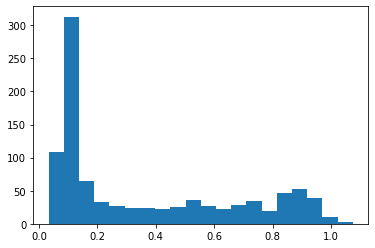

<IPython.core.display.Javascript object>

In [121]:
plt.hist(sd[:, 1], bins=20)

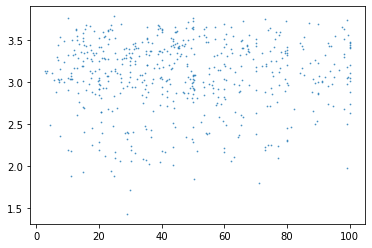

<IPython.core.display.Javascript object>

In [60]:
price_id = features["val"] < 100
plt.scatter(features["val"][price_id], m[price_id, 0], alpha=0.7, s=0.6)

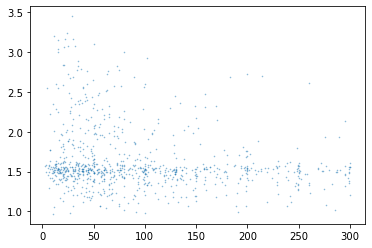

<IPython.core.display.Javascript object>

In [58]:
price_id = features["val"] < 300
plt.scatter(features["val"][price_id], m[price_id, 1], alpha=0.5, s=0.3)

In [130]:
features["brand"].value_counts()

Sony                   51
Pyle                   49
Yamaha Audio           38
Sennheiser             35
Polk Audio             33
                       ..
Digital Group Audio     1
turelar                 1
Power Acoustik          1
Chief                   1
Bell'O Digital          1
Name: brand, Length: 269, dtype: int64

<IPython.core.display.Javascript object>

In [72]:
inferred_rho.shape

(959, 5000, 2)

<IPython.core.display.Javascript object>

In [73]:
features.shape

(959, 8)

<IPython.core.display.Javascript object>

In [74]:
features.head()


,asin,val,productGroup,brand,num_reviews,top_10,log_val,log_num_reviews
0,B00000K2YR,77.860,Speakers,Midland,1249,N,4.367674,7.130899
1,B00001P4XA,17.530,Speakers,Koss,1079,N,2.919391,6.984716
2,B00001P4XH,9.010,Speakers,Koss,962,N,2.303585,6.870053
3,B00001P4ZH,39.355,Speakers,Koss,3404,N,3.697715,8.133000
4,B00001P505,22.955,Speakers,Koss,444,N,3.176177,6.098074


<IPython.core.display.Javascript object>

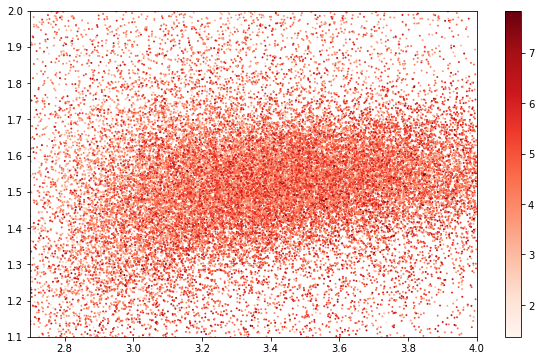

<IPython.core.display.Javascript object>

In [91]:
plt.figure(figsize=(10, 6))
plt.scatter(
    inferred_rho[:, ::100, 0].flatten(),
    inferred_rho[:, ::100, 1].flatten(),
    c=np.tile(np.array(features["log_val"])[:, None], (1, 50)).flatten(),
    s=0.9,
    cmap="Reds",
)
plt.xlim([2.7, 4.0])
plt.ylim([1.1, 2.0])
plt.colorbar()

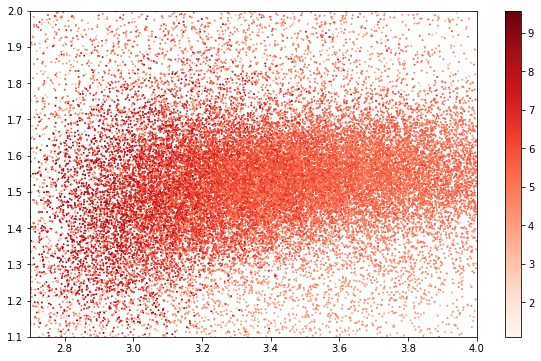

<IPython.core.display.Javascript object>

In [92]:
plt.figure(figsize=(10, 6))
plt.scatter(
    inferred_rho[:, ::100, 0].flatten(),
    inferred_rho[:, ::100, 1].flatten(),
    c=np.tile(np.array(features["log_num_reviews"])[:, None], (1, 50)).flatten(),
    s=0.9,
    cmap="Reds",
)
plt.xlim([2.7, 4.0])
plt.ylim([1.1, 2.0])
plt.colorbar()

(0.8, 2.4)

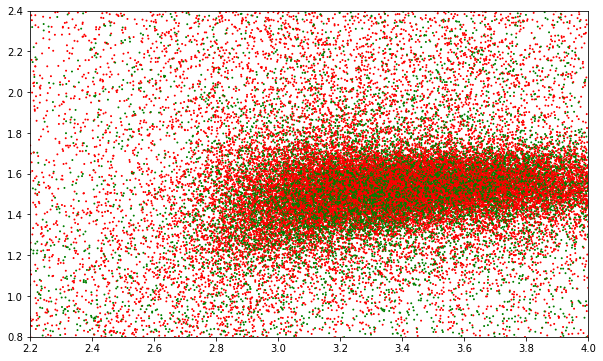

<IPython.core.display.Javascript object>

In [110]:
plt.figure(figsize=(10, 6))
c_array = np.tile(np.array(features["top_10"])[:, None], (1, 50)).flatten()
plt.scatter(
    inferred_rho[:, ::100, 0].flatten(),
    inferred_rho[:, ::100, 1].flatten(),
    c=["red" if i is "N" else "green" for i in c_array],
    s=0.9,
    cmap="Reds",
)
plt.xlim([2.2, 4.0])
plt.ylim([0.8, 2.4])

Text(0, 0.5, 'rho_1')

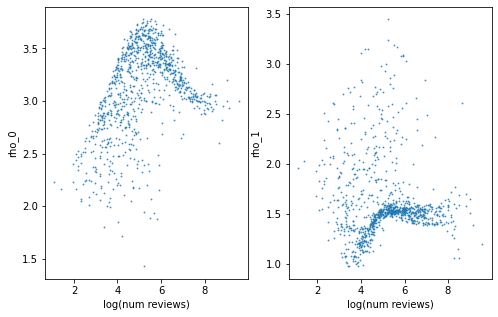

<IPython.core.display.Javascript object>

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].scatter(
    features["log_num_reviews"],
    np.mean(inferred_rho[:, :, 0], axis=1),
    alpha=0.7,
    s=0.8,
)
ax[0].set_xlabel("log(num reviews)")
ax[0].set_ylabel("rho_0")
ax[1].scatter(
    features["log_num_reviews"],
    np.mean(inferred_rho[:, :, 1], axis=1),
    alpha=0.7,
    s=0.8,
)
ax[1].set_xlabel("log(num reviews)")
ax[1].set_ylabel("rho_1")

Text(0, 0.5, 'rho_1')

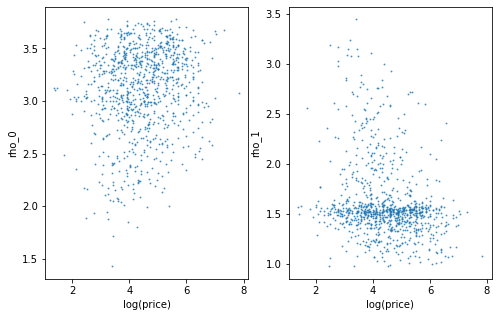

<IPython.core.display.Javascript object>

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].scatter(
    features["log_val"],
    np.mean(inferred_rho[:, :, 0], axis=1),
    alpha=0.7,
    s=0.8,
)
ax[0].set_xlabel("log(price)")
ax[0].set_ylabel("rho_0")
ax[1].scatter(
    features["log_val"],
    np.mean(inferred_rho[:, :, 1], axis=1),
    alpha=0.7,
    s=0.8,
)
ax[1].set_xlabel("log(price)")
ax[1].set_ylabel("rho_1")

(0.8, 2.4)

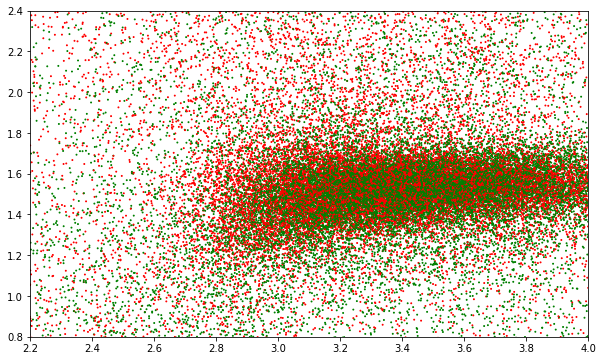

<IPython.core.display.Javascript object>

In [121]:
plt.figure(figsize=(10, 6))
c_array = np.tile(np.array(features["log_val"])[:, None], (1, 50)).flatten()
plt.scatter(
    inferred_rho[:, ::100, 0].flatten(),
    inferred_rho[:, ::100, 1].flatten(),
    c=["red" if i < np.mean(features["log_val"]) else "green" for i in c_array],
    s=0.9,
)
plt.xlim([2.2, 4.0])
plt.ylim([0.8, 2.4])

In [122]:
rho_below_price_mean = inferred_rho[
    [True if i < np.mean(features["log_val"]) else False for i in features["log_val"]],
    :,
    :,
]

<IPython.core.display.Javascript object>

In [123]:
rho_above_price_mean = inferred_rho[
    [True if i >= np.mean(features["log_val"]) else False for i in features["log_val"]],
    :,
    :,
]

<IPython.core.display.Javascript object>

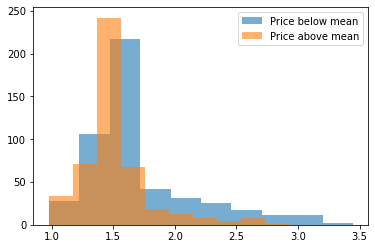

<IPython.core.display.Javascript object>

In [135]:
plt.hist(
    np.mean(rho_below_price_mean[:, :, 1], axis=1), alpha=0.6, label="Price below mean"
)
plt.hist(
    np.mean(rho_above_price_mean[:, :, 1], axis=1), alpha=0.6, label="Price above mean"
)
plt.legend()

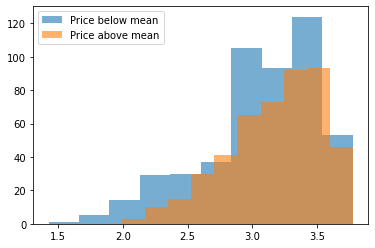

<IPython.core.display.Javascript object>

In [136]:
plt.hist(
    np.mean(rho_below_price_mean[:, :, 0], axis=1), alpha=0.6, label="Price below mean"
)
plt.hist(
    np.mean(rho_above_price_mean[:, :, 0], axis=1), alpha=0.6, label="Price above mean"
)
plt.legend()

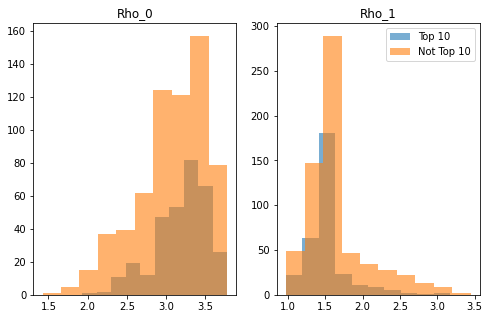

<IPython.core.display.Javascript object>

In [139]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].hist(features["rho0"][features["top_10"] == "Y"], alpha=0.6, label="Top 10")
ax[0].hist(features["rho0"][features["top_10"] == "N"], alpha=0.6, label="Not Top 10")
ax[0].set_title("Rho_0")
ax[1].hist(features["rho1"][features["top_10"] == "Y"], alpha=0.6, label="Top 10")
ax[1].hist(features["rho1"][features["top_10"] == "N"], alpha=0.6, label="Not Top 10")
ax[1].set_title("Rho_1")
plt.legend()

In [142]:
print(features.groupby("top_10")["rho0"].mean())
print(features.groupby("top_10")["rho1"].mean())

top_10
N    3.078860
Y    3.194289
Name: rho0, dtype: float64
top_10
N    1.651348
Y    1.534110
Name: rho1, dtype: float64


<IPython.core.display.Javascript object>

In [143]:
from scipy.stats import ttest_ind

<IPython.core.display.Javascript object>

In [144]:
ttest_ind(features["rho0"][features["top_10"] == "Y"], features["rho0"][features["top_10"] == "N"])

Ttest_indResult(statistic=4.1343458315782495, pvalue=3.8719943051105116e-05)

<IPython.core.display.Javascript object>

In [145]:
ttest_ind(
    features["rho1"][features["top_10"] == "Y"],
    features["rho1"][features["top_10"] == "N"],
)

Ttest_indResult(statistic=-4.484616489420178, pvalue=8.189996540223272e-06)

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='rho0', ylabel='rho1'>

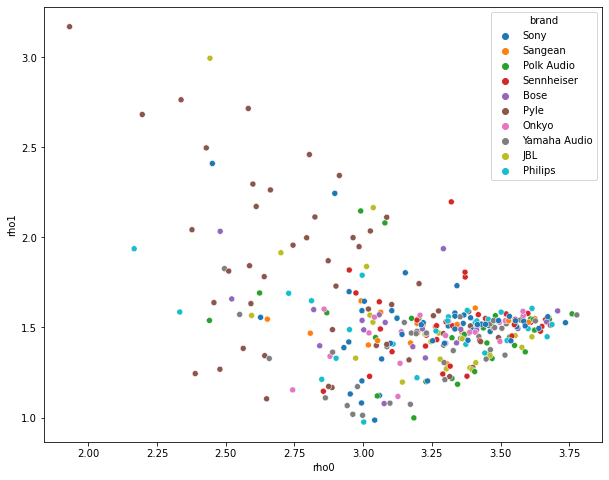

<IPython.core.display.Javascript object>

In [160]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=features.loc[features["top_10"] == "Y", :], x="rho0", y="rho1", hue="brand"
)

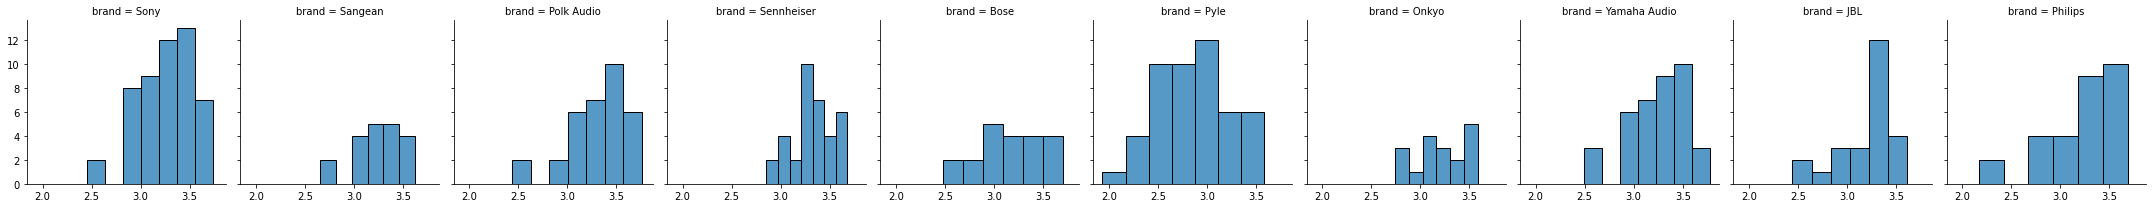

<IPython.core.display.Javascript object>

In [170]:
g = sns.FacetGrid(features.loc[features["top_10"] == "Y", :], col="brand")
g.map_dataframe(sns.histplot, x="rho0")

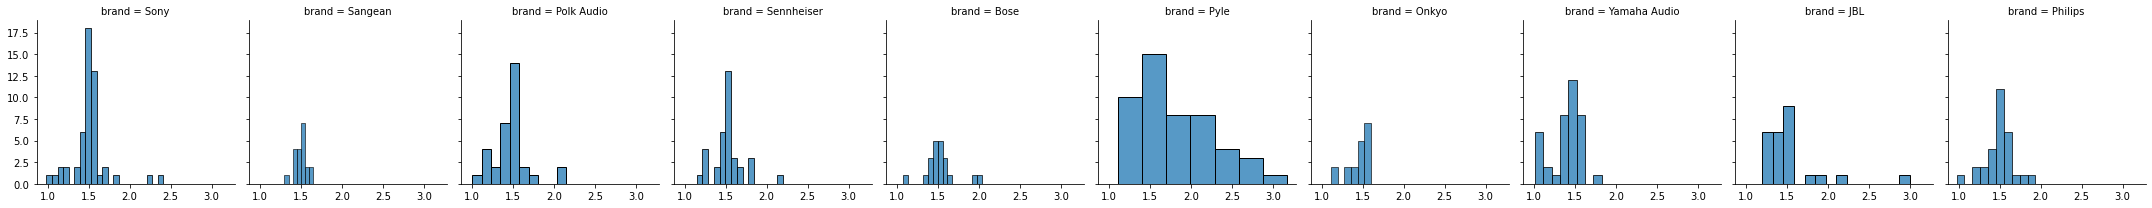

<IPython.core.display.Javascript object>

In [168]:
g = sns.FacetGrid(features.loc[features["top_10"] == "Y", :], col="brand")
g.map_dataframe(sns.histplot, x="rho1")